In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import torch 
import torch.nn.functional as F
from sympy.vector import Laplacian
from torch.autograd.functional import hessian
from torch.distributions.multivariate_normal import MultivariateNormal
import seaborn as sns

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Favor <u>não</u> enviar um .zip dos arquivos.
Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um **<u>*único pdf*</u>**.

# Trabalho de casa 03: Regressão logística e inferência Bayesiana aproximada

O pedaço de código abaixo carrega o banco de dados 'breast cancer' e adiciona uma coluna de bias. Além disse, ele o particiona em treino e teste.

1. Implemente a estimativa de máximo a posteriori para um modelo de regressão logística com priori $\mathcal{N}(0, c I)$ com $c=100$ usando esse banco de dados;
2. Implemente a aproximação de Laplace para o mesmo modelo;
3. Implemente uma aproximação variacional usando uma Gaussiana diagonal e o truque da reparametrização;
4. Calcule a accuracy no teste para todas as opções acima --- no caso das 2 últimas, a prob predita é $\int_\theta p(y|x, \theta) q(\theta)$;
5. Para cada uma das 3 técnicas, plote um gráfico com a distribuição das entropias para as predições corretas e erradas (separadamente), use a função kdeplot da biblioteca seaborn.
6. Comente os resultados, incluindo uma comparação dos gráficos das entropias.

Explique sua implementação também! 

Para facilitar sua vida: use PyTorch, Adam para otimizar (é uma variação SGD) com lr=0.001, use o banco de treino inteiro ao invés de minibatchces, use `binary_cross_entropy_with_logits` para implementar a -log verossimilhança, use `torch.autograd.functional` para calcular a Hessiana. Você pode usar as bibliotecas importadas na primeira célula à vontade. Verifique a documentação de `binary_cross_entropy_with_logits` para garantir que a sua priori está implementada corretamente, preservando as proporções devidas. Use 10000 amostras das aproximações para calcular suas predições.

In [2]:
data =  load_breast_cancer()
N = len(data.data)
Ntrain = int(np.ceil(N*0.6))
perm = np.random.permutation(len(data.data))
X = torch.tensor(data.data).float()
X = torch.cat((X, torch.ones((X.shape[0], 1))), axis=1) 
y = torch.tensor(data.target).float()

Xtrain, ytrain = X[perm[:Ntrain]], y[perm[:Ntrain]]
Xtest, ytest = X[perm[Ntrain:]], y[perm[Ntrain:]]

In [3]:

    
def maximum_a_posteriori(X: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    priori_var = 100
    learning_rate = 0.001

    d = X.shape[1]

    theta = torch.empty(d).normal_(std=priori_var ** 0.5).requires_grad_(True)
    optimizer = torch.optim.Adam([theta], lr=learning_rate)
    prior = MultivariateNormal(torch.zeros(d), priori_var * torch.eye(d))
    for _ in range(100000):
        optimizer.zero_grad()
        log_likelihood = F.binary_cross_entropy_with_logits(X @ theta, y, reduction='sum')
        log_prior = -prior.log_prob(theta)
        loss = log_likelihood + log_prior
        loss.backward()
        optimizer.step()
        if theta.grad.norm() < 1e-3:
            print("stop")
            break
        
    return theta
    

theta = maximum_a_posteriori(Xtrain, ytrain)
pred_map = Xtest@theta


In [4]:
def laplacian(X: torch.Tensor, y: torch.Tensor):
    mode = maximum_a_posteriori(X,y)
    prior = MultivariateNormal(torch.zeros(X.shape[1]), 100 * torch.eye(X.shape[1]))
    log_posterior = lambda theta: F.binary_cross_entropy_with_logits(X @ theta, y, reduction="sum") - prior.log_prob(theta)
    hessian_posterior = hessian(log_posterior, mode)

    covariance_matrix = torch.inverse(hessian_posterior)
    # a matriz de covariância deve ser simétrica, mas problemas numéricos podem fazer com que ela não seja
    # então, forçamos simetria
    covariance_matrix = (covariance_matrix + covariance_matrix.t()) / 2 
    return MultivariateNormal(mode, covariance_matrix)


laplacian_approx = laplacian(Xtrain,ytrain)


In [19]:
def laplacian_pred(X, laplacian_posterior):
    samples = laplacian_posterior.sample((10_000,))
    y_pred = X.mm(samples.t()).mean(dim=1)
    return y_pred

pred_laplacian = laplacian_pred(Xtest,laplacian_approx)

In [15]:
def variational_inference(X: torch.Tensor, y: torch.Tensor):
    priori_var = 100
    learning_rate = 0.001
    d = X.shape[1]
    mu = torch.zeros(d).requires_grad_(True)
    sigma = torch.ones(d).requires_grad_(True)
    optimizer = torch.optim.Adam([mu, sigma], lr=learning_rate)
    for _ in range(100_000):
        optimizer.zero_grad()
        q = MultivariateNormal(mu, torch.diag(sigma ** 2))
        theta = q.rsample()
        log_likelihood = F.binary_cross_entropy_with_logits(X @ theta, y, reduction='sum')
        log_prior = -q.log_prob(theta)
        kl = q.entropy()
        loss = log_likelihood + log_prior + kl
        loss.backward()
        optimizer.step()
        if mu.grad.norm() < 1e-3 or sigma.grad.norm() < 1e-3:
            print("stop")
            break
    return q
var_aprox_posterior = variational_inference(Xtrain, ytrain)

In [21]:
def variational_pred(X, variational_posterior):
    samples = variational_posterior.sample((10_000,))
    y_pred = X.mm(samples.t()).mean(dim=1)
    return y_pred

var_pred = variational_pred(Xtest, var_aprox_posterior)

In [22]:
def accuracy(y_pred, y_true):
    y_pred = torch.sigmoid(y_pred)
    y_pred = (y_pred > 0.5).float()
    return (y_pred == y_true).float().mean()

print(f"MAP accuracy: {accuracy(pred_map, ytest)}")
print(f"Laplace accuracy: {accuracy(pred_laplacian, ytest)}")
print(f"Variational accuracy: {accuracy(var_pred, ytest)}")

MAP accuracy: 0.9515418410301208
Laplace accuracy: 0.9559471607208252
Variational accuracy: 0.9603524208068848


In [23]:
def entropy_grafics(ax,y_pred, y_true):
    y_pred = torch.sigmoid(y_pred)
    correct = (y_pred > 0.5).float() == y_true
    incorrect = ~correct
    sns.kdeplot((-y_pred[correct]*torch.log(y_pred[correct])).detach().numpy(), label="correct", ax=ax)
    sns.kdeplot((-y_pred[incorrect]*torch.log(y_pred[incorrect])).detach().numpy(), label="incorrect", ax=ax)

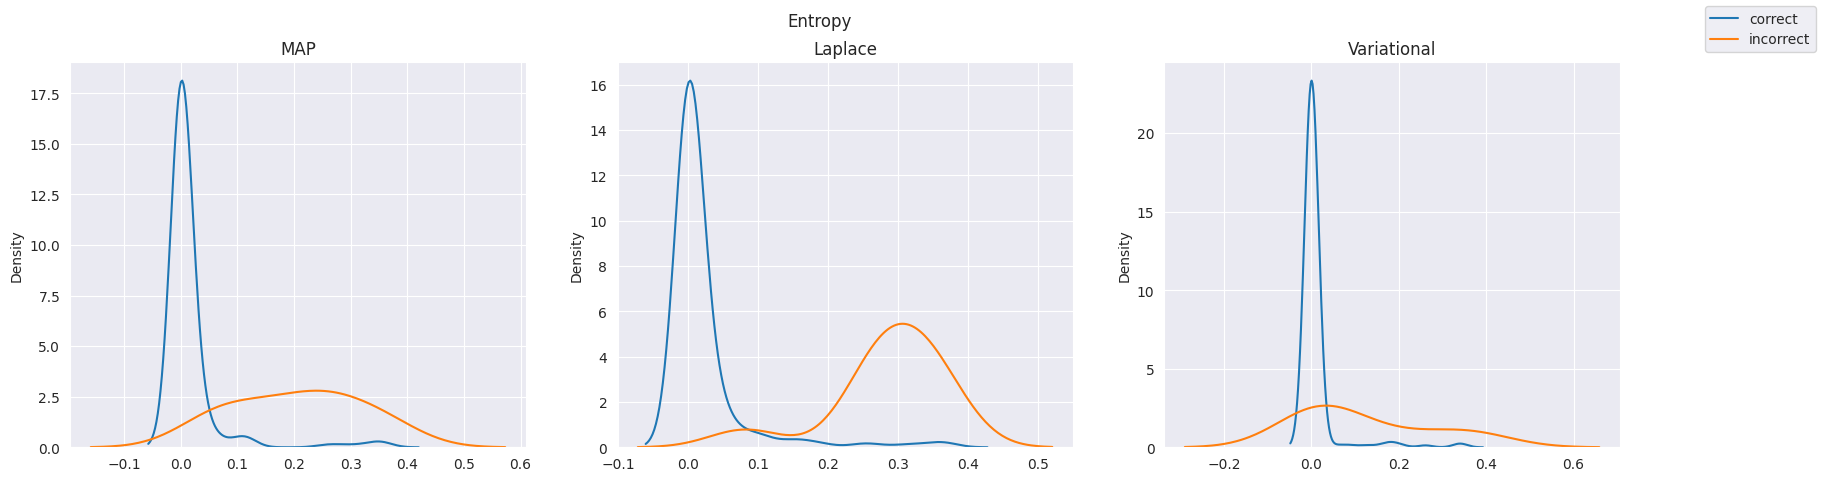

In [24]:
fig, axs = plt.subplots(1,3, figsize=(20, 5))
entropy_grafics(axs[0],pred_map, ytest)
axs[0].set_title("MAP")
fig.legend()
entropy_grafics(axs[1],pred_laplacian, ytest) 
axs[1].set_title("Laplace")
entropy_grafics(axs[2],var_pred, ytest)
axs[2].set_title("Variational")
fig.suptitle("Entropy")
plt.show()

# Exercícios de "papel e caneta"

1. Derive a fórmula para a divergência KL entre duas distribuições Gaussianas univariadas, i.e., $D_\text{KL}\left(\mathcal{N}(\mu_1, \sigma_1^2) \| \mathcal{N}(\mu_2, \sigma_2^2)\right)$;

2. Suponha que $P$ é a família das distribuições categóricas com suporte em $\{1,\ldots, L\}$. Qual $p \in P$ possui maior entropia? 

3. Use a [desigualdade de Jensen](https://en.wikipedia.org/wiki/Jensen%27s_inequality) para mostrar que a divergência KL é não-negativa.

> **Dica:** A desigualdade de Jensen afirma que, se $\varphi$ é uma função convexa, então $\varphi(\mathbb{E}[X]) \leq \mathbb{E}[\varphi(X)]$.

4. Derive a aproximação de Laplace para a distribuição [Beta](https://en.wikipedia.org/wiki/Beta_distribution)($\alpha, \beta$). Mostre uma fórmula para valores genéricos $\alpha,\beta>1$ e a instancie para $\alpha=\beta=2$.

5. Derive a posteriori para o modelo Bayesiano com verossimilhança [Categórica](https://en.wikipedia.org/wiki/Categorical_distribution) e priori [Dirichlet](https://en.wikipedia.org/wiki/Dirichlet_distribution), i.e.:
$$
\begin{align}{2}
y_1,\ldots, y_N &\sim Cat(\mathbf{\theta})\\
\mathbf{\theta} &\sim Dirichlet(\mathbf{\alpha})
\end{align}
$$
onde $\mathbf{\theta}$ e $\mathbf{\alpha}$ são vetores $L$-dimensionais.


### Questão 1
$$
\begin{align}
D_\text{KL}\left(\mathcal{N}(\mu_1, \sigma_1^2) \| \mathcal{N}(\mu_2, \sigma_2^2)\right) &= E_{\mathcal{N}(\mu_1,\sigma_1)}\left[\log{\frac{\mathcal{N}(\mu_1,\sigma^2_1)}{\mathcal{N}(\mu_2,\sigma^2_2)}}\right]\\
&=E_{\mathcal{N}(\mu_1,\sigma_1)}\left[\log{\mathcal{N}(\mu_1,\sigma^2_1)}\right]-E_{\mathcal{N}(\mu_1,\sigma_1)}\left[\log{\mathcal{N}(\mu_2,\sigma^2_2)}\right]\\
&=E_{\mathcal{N}(\mu_1,\sigma_1)}\left\{\log\left[(2\pi\sigma^2_1)^{-\frac{1}{2}}\exp{\left[-\frac{1}{2}\left(\frac{x-\mu_1}{\sigma_1}\right)^2\right]}\right]\right\}-
E_{\mathcal{N}(\mu_1,\sigma_1)}\left\{\log\left[(2\pi\sigma^2_2)^{-\frac{1}{2}}\exp{\left[-\frac{1}{2}\left(\frac{x-\mu_2}{\sigma_2}\right)^2\right]}\right]\right\}\\
&=-\frac{1}{2}\left\{E_{\mathcal{N}(\mu_1,\sigma_1)}\left[\log(2\pi\sigma_1^2)\right]-E_{\mathcal{N}(\mu_1,\sigma_1)}\left[\log(2\pi\sigma_2^2)\right]+
E_{\mathcal{N}(\mu_1,\sigma_1)}\left[\left(\frac{x-\mu_1}{\sigma_1}\right)^2\right]-E_{\mathcal{N}(\mu_1,\sigma_1)}\left[\left(\frac{x-\mu_2}{\sigma_2}\right)^2\right]\right\}\\
&=-\frac{1}{2}\left\{\log(\sigma_1^2)-\log(\sigma_2^2)+
\frac{\sigma_1^2}{\sigma_1^2}-\frac{\mu_1^2+\sigma_1^2-2\mu_1\mu_2+\mu_2^2}{\sigma_2^2}\right\}\\
&=-\frac{1}{2}\left\{\log\frac{\sigma_1^2}{\sigma_2^2}+1-\frac{\sigma_1^2}{\sigma_2^2}-\frac{(\mu_1-\mu_2)^2}{\sigma_2^2}\right\}\\
\end{align}
$$


## Questão 2
$$H(p)=-\sum_{i=1}^{L}{p_i\log{p_i}}$$
para encontrar, a distribuição que maximiza a entropia, devemos maximizar a função $H(p)$ sujeita a restrição $\sum_{i=1}^{L}{p_i}=1$.
Para isso, usamos o método dos multiplicadores de Lagrange:
$$\mathcal{L}(p,\lambda)=-\sum_{i=1}^{L}{p_i\log{p_i}}+\lambda\left(\sum_{i=1}^{L}{p_i}-1\right)$$
$$\frac{\partial \mathcal{L}}{\partial p_i}=-\log{p_i}-1+\lambda=0$$
$$p_i=e^{-1+\lambda}$$
$$\sum_{i=1}^{L}{e^{-1+\lambda}}=1$$
$$Le^{-1+\lambda}=1$$
$$e^{-1+\lambda}=1/L$$
$$p_i=1/L$$
Portanto, a distribuição que maximiza a entropia é a distribuição uniforme.

## Questão 3
$$D_{KL}(q\|p)=\mathbb{E}_{\bold{\theta}\sim q}\left[\log\frac{q(\bold{\theta})}{p(\bold{\theta})}\right]=\mathbb{E}_{\bold{\theta}\sim q}\left[-\log\frac{p(\bold{\theta})}{q(\bold{\theta})}\right]$$
$-\log(x)$ é uma função convexa, logo vale a desigualdade de Jensen:
$$ \mathbb{E}_{\bold{\theta}\sim q}\left[-\log\frac{p(\bold{\theta})}{q(\bold{\theta})}\right]\geq-\log\mathbb{E}_{\bold{\theta}\sim q}\left[\frac{p(\bold{\theta})}{q(\bold{\theta})}\right]$$
$$ D_{KL}(q\|p)\geq-\log\left[\int_\Theta{\frac{p(\bold{\theta})}{q(\bold{\theta})}q(\bold{\theta})d\theta}\right]$$
$$ D_{KL}(q\|p)\geq-\log\left[\int_\Theta{p(\bold{\theta})d\theta}\right]$$
$$ D_{KL}(q\|p)\geq-\log\left[1\right]$$
$$ D_{KL}(q\|p)\geq0$$ 
cqd.

# Questão 4
$$X\sim Beta(a,b)$$
$$f(x)=\frac{1}{\beta(a,b)}x^{a-1}(1-x)^{b-1}$$
$$\log[f(x)]=l(x)=(a-1)\log{x}+(b-1)\log{(1-x)}-\log{\beta(a,b)}$$
$$\frac{\partial l(x)}{\partial x}=\frac{a-1}{x}+\frac{b-1}{1-x}$$
$$\frac{\partial^2 l(x)}{\partial x^2}=\frac{1-a}{x^2}+\frac{1-b}{(1-x)^2}$$
Como $X$ é distribuído por $Beta(a,b)$, a moda de $X$ é $\frac{a-1}{a+b-2}$ para $a,b>1$. Com isso podemos encontrar a aproximação de laplace:
$$-\frac{\partial^2 l(\frac{a-1}{a+b-2})}{\partial x^2}=\frac{a-1}{\left(\frac{a-1}{a+b-2}\right)^2}+\frac{b-1}{\left(1-\frac{a-1}{a+b-2}\right)^2}$$
$$-\frac{\partial^2 l(\frac{a-1}{a+b-2})}{\partial x^2}=\frac{(a+b-2)^2}{a-1}+\frac{(b-1)(a+b-2)^2}{(a+b-2-a+1)^2}$$
$$-\frac{\partial^2 l(\frac{a-1}{a+b-2})}{\partial x^2}=\frac{(a+b-2)^2}{a-1}+\frac{((a+b-2)^2}{b-1}$$
$$-\frac{\partial^2 l(\frac{a-1}{a+b-2})}{\partial x^2}=\frac{(a+b-2)^3}{(a-1)(b-1)}$$
A aproximação de Laplace para a distribuição beta é $\frac{(a+b-2)^3}{(a-1)(b-1)}$

## Questão 5
$$Y|\theta\sim Cat(\theta)$$
$$\theta\sim Dir(\alpha)$$
$$f_n(y|\theta)=\prod_{j=1}^{N}\prod_{i=1}^{L}{\theta_i^{[y_j=y_i]}}$$
$$f(\theta)=\frac{1}{\beta(\alpha)}\prod_{i=1}^{L}{\theta_i^{\alpha_i-1}$$
$$f(\theta|y)\propto f(y|\theta)f(\theta)$$
$$f(\theta|y)\propto\prod_{i=1}^{L}\left({\theta_i^{\alpha-1}\prod_{j=1}^N\theta_i^{[y_j=y_i]}\right)$$
$$f(\theta|y)\propto\prod_{i=1}^{L}\left({\theta_i^{\alpha-1+\sum_{j=1}^N[y_j=y_i]}\right)$$
$$f(\theta|y)\propto\prod_{i=1}^{L}\left({\theta_i^{\alpha_i+\sum_{j=1}^N[y_j=y_i]}\right)$$
$$f(\theta|y)\propto Dir(\alpha+\sum_{j=1}^N[y_j=y_i])$$
Portanto, a posteriori é $Dir(\alpha+\sum_{j=1}^N[y_j=y_i])$
